In [1]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from ucimlrepo import fetch_ucirepo 

pd.options.mode.chained_assignment = None

In [2]:
# fetch dataset from the UCI archive website by its ID. 
drug_dataset_id = 462
Drugs = fetch_ucirepo(id=drug_dataset_id) 

In [3]:
# variable info. 
print(Drugs.metadata["additional_info"]["variable_info"]) 

1. drugName (categorical): name of drug
2. condition (categorical): name of condition
3. review (text): patient review
4. rating (numerical): 10 star patient rating
5. date (date): date of review entry
6. usefulCount (numerical): number of users who found review useful


In [4]:
# Create a total data from the Drugs
data_original = Drugs.data.original

# Checking for missing values in the dataset
missing_values = data_original.isnull().sum()

# Drop the rows with the missing condition value.
data_original = data_original.dropna()

# Drop the rows with an improper condition. rows with </span> do not include a real condition.
span_count = data_original['condition'].str.contains('</span>', na=False).sum()
data_original = data_original[~data_original['condition'].str.contains('</span>', na=False)]

# Basic summary statistics for numerical columns
numerical_summary = data_original.describe()

# Distribution of unique values for categorical columns
drug_count = data_original['drugName'].nunique()
condition_count = data_original['condition'].nunique()

# Summarize text review column (average length of reviews)
data_original['review_length'] = data_original['review'].apply(lambda x: len(x.split()))

average_review_length = data_original['review_length'].mean()

# Display key stats
print(f"Missing Values \n{missing_values}\n")
print(f'Number of rows with "</span>": {span_count}')
print(f"Numerical Summary: \n{numerical_summary}\n")
print(f"Number of unique drugs: {drug_count}")
print(f"Number of unique conditions: {condition_count}")
print(f"Average length of review: {round(average_review_length)}")

Missing Values 
id                0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

Number of rows with "</span>": 1171
Numerical Summary: 
                  id         rating    usefulCount
count  212698.000000  212698.000000  212698.000000
mean   116079.388673       6.992431      28.186819
std     66999.171961       3.275994      36.455651
min         0.000000       1.000000       0.000000
25%     58154.250000       5.000000       6.000000
50%    115961.500000       8.000000      16.000000
75%    174009.750000      10.000000      37.000000
max    232291.000000      10.000000    1291.000000

Number of unique drugs: 3654
Number of unique conditions: 836
Average length of review: 85


In [5]:
# Convert 'date' column to datetime format
data_original['date'] = pd.to_datetime(data_original['date'], format="%d-%b-%y", errors='coerce')

# Extract year from the date
data_original['year'] = data_original['date'].dt.year
# Extract the month from the date
data_original['month'] = data_original['date'].dt.month

# Group data by year and month, and calculate the number of reviews and average rating
data_original['year_month'] = data_original['date'].dt.to_period('M')

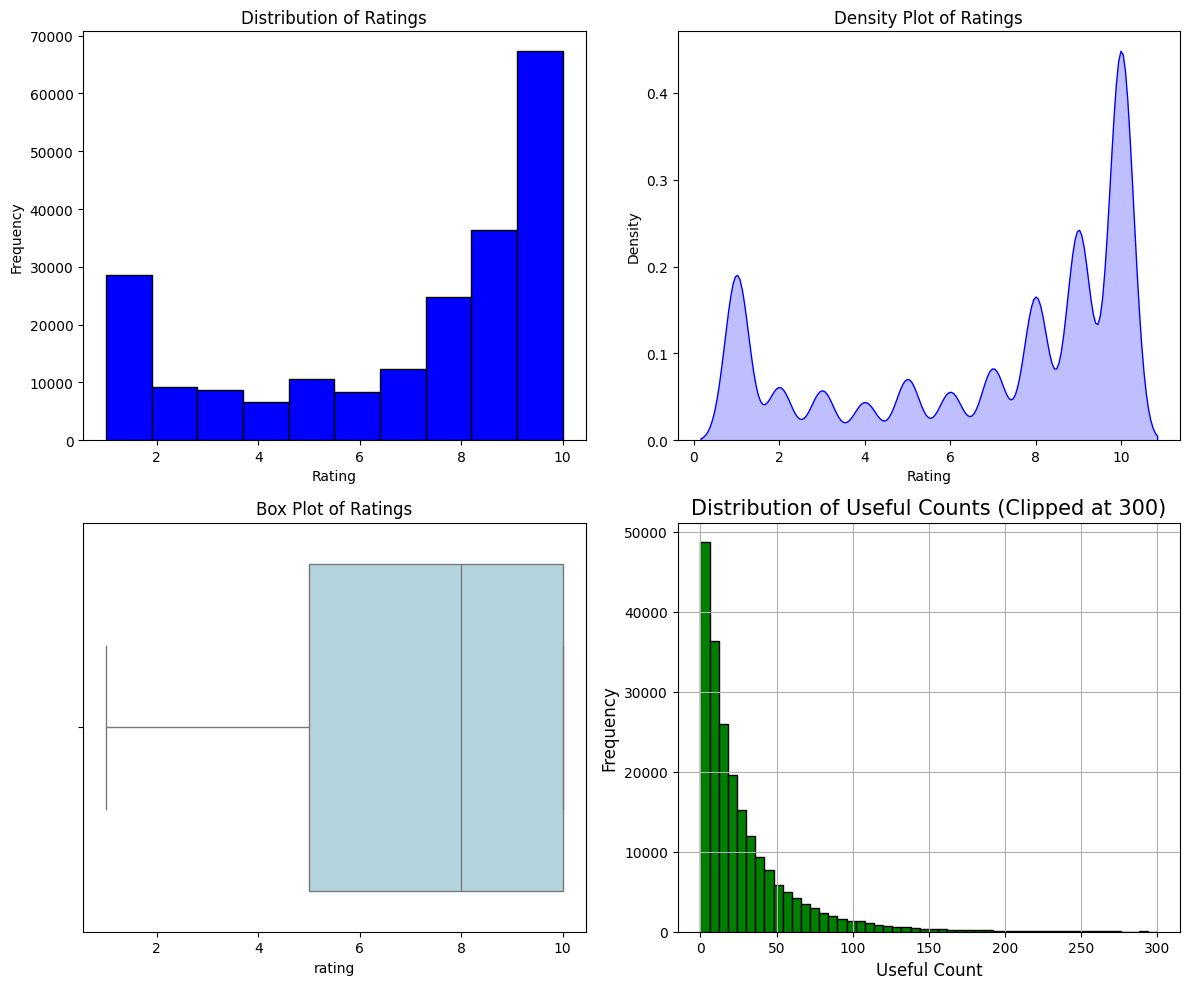

In [6]:
# Histogram for numerical variables (rating and usefulCount, assuming they exist)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].hist(data_original["rating"], bins=10, edgecolor="black", color="blue")
axs[0, 0].set_title('Distribution of Ratings')
axs[0, 0].set_xlabel('Rating')
axs[0, 0].set_ylabel('Frequency')

sns.kdeplot(data_original['rating'], fill=True, color='blue', ax=axs[0, 1])
axs[0, 1].set_title('Density Plot of Ratings')
axs[0, 1].set_xlabel('Rating')
axs[0, 1].set_ylabel('Density')
plt.grid(True)

# Box plots to show spread and outliers
sns.boxplot(x=data_original["rating"], color="lightblue", ax=axs[1, 0])
axs[1, 0].set_title("Box Plot of Ratings")

# Distribution of Useful counts plot
axs[1, 1].hist(data_original['usefulCount'], bins=50, color='green', edgecolor='black', range=(0, 300))
axs[1, 1].set_title('Distribution of Useful Counts (Clipped at 300)', fontsize=15)
axs[1, 1].set_xlabel('Useful Count', fontsize=12)
axs[1, 1].set_ylabel('Frequency', fontsize=12)
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

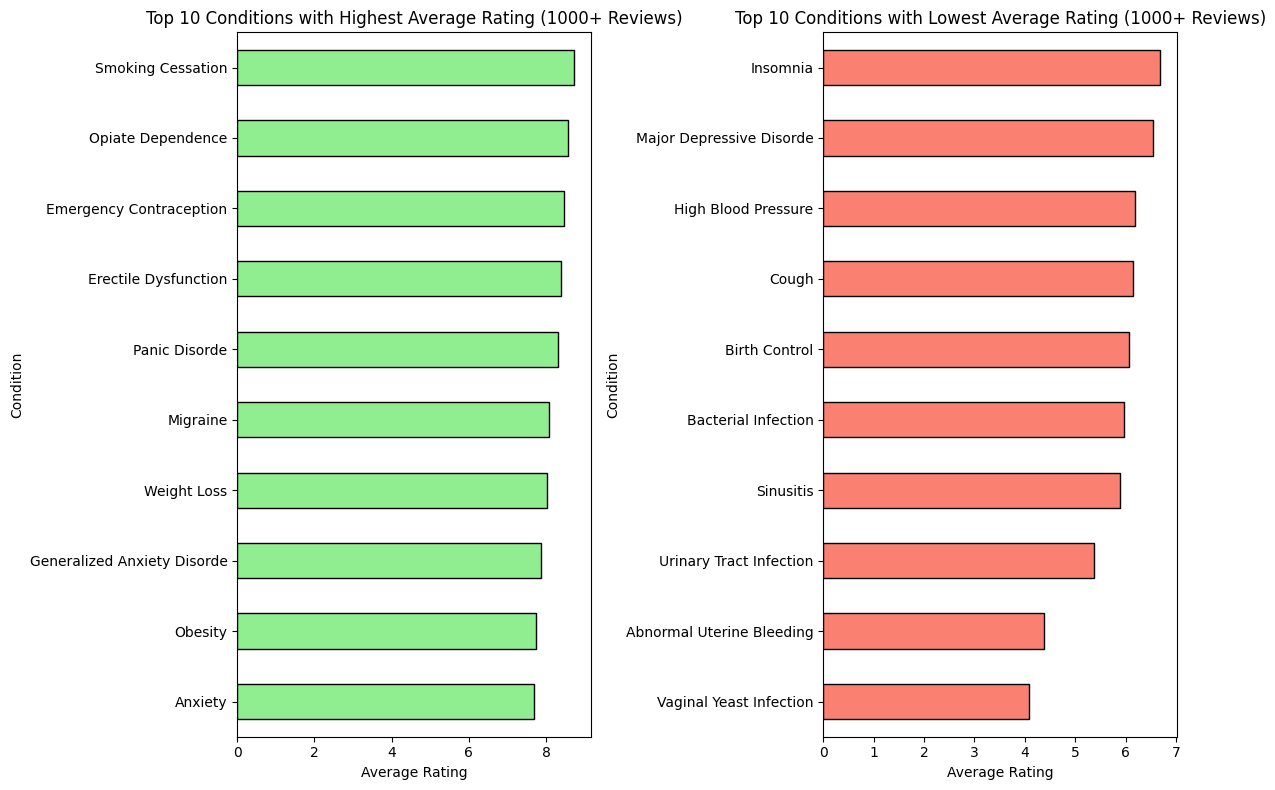

In [7]:
# Calculate the average rating for each condition
avg_rating_per_condition = data_original.groupby("condition")["rating"].mean()
condition_review_counts = data_original.groupby("condition").size()  # Count the number of reviews for each condition

conditions_at_least_1000_reviews = condition_review_counts[condition_review_counts >= 1000].index
filtered_avg_ratings = avg_rating_per_condition.loc[conditions_at_least_1000_reviews]

# Sort the conditions by average rating
sorted_ratings = filtered_avg_ratings.sort_values()

# Visualize the top 10 highest and lowest rated conditions with at least 100 reviews
plt.figure(figsize=(12, 8))

# Plot the top 10 highest rated conditions
plt.subplot(1, 2, 1)
sorted_ratings.tail(10).plot(kind="barh", color="lightgreen", edgecolor="black")
plt.title("Top 10 Conditions with Highest Average Rating (1000+ Reviews)")
plt.xlabel("Average Rating")
plt.ylabel("Condition")

# Plot the top 10 lowest rated conditions
plt.subplot(1, 2, 2)
sorted_ratings.head(10).plot(kind="barh", color="salmon", edgecolor="black")
plt.title("Top 10 Conditions with Lowest Average Rating (1000+ Reviews)")
plt.xlabel("Average Rating")
plt.ylabel("Condition")

# Display the plots
plt.tight_layout()
plt.show()

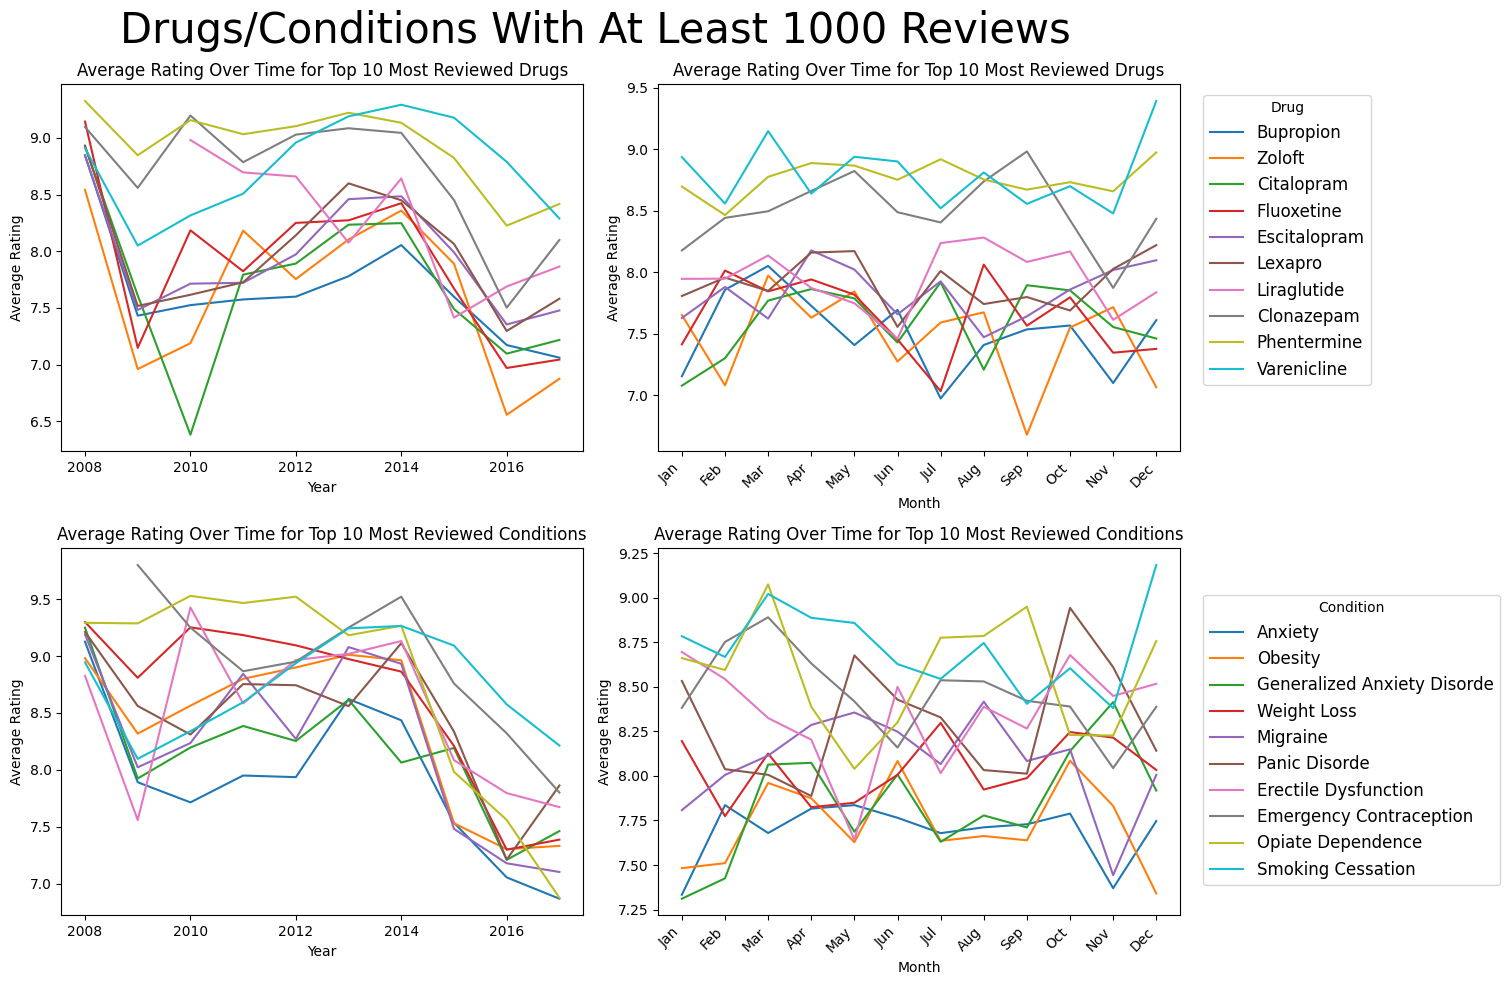

In [8]:
# string arr of all of the months in a year, used for the x ticks
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#Including the effect of time aka including the date information
avg_rating_per_drug = data_original.groupby("drugName")["rating"].mean()
drug_review_counts = data_original.groupby("drugName").size()

drugs_at_least_1000_reviews = drug_review_counts[drug_review_counts >= 1000].index
filtered_avg_drug_ratings = avg_rating_per_drug.loc[drugs_at_least_1000_reviews]

# Sort the conditions by average rating
sorted_drug_ratings = filtered_avg_drug_ratings.sort_values()

# Identify the top 10 most used drugs (based on number of reviews)
top_10_drugs = sorted_drug_ratings.tail(10).index

top_10_conditions = sorted_ratings.tail(10).index

# Group by drug and year/month, then calculate the average rating
ratings_by_year_top_drugs = data_original[data_original['drugName'].isin(top_10_drugs)].groupby(['drugName', 'year'])['rating'].mean().reset_index()
ratings_by_month_top_drugs = data_original[data_original['drugName'].isin(top_10_drugs)].groupby(['drugName', 'month'])['rating'].mean().reset_index()

# Group by condition and year/month, then calculate the average rating
ratings_by_year_top_conditions = data_original[data_original['condition'].isin(top_10_conditions)].groupby(['condition', 'year'])['rating'].mean().reset_index()
ratings_by_month_top_conditions = data_original[data_original['condition'].isin(top_10_conditions)].groupby(['condition', 'month'])['rating'].mean().reset_index()


# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Drugs/Conditions With At Least 1000 Reviews', fontsize=30)

# Plotting for each drug and condition
for i in range(len(top_10_drugs)):
    drug = top_10_drugs[i]
    sns.lineplot(x='year', y='rating', data=ratings_by_year_top_drugs[ratings_by_year_top_drugs['drugName'] == drug], label=drug, ax=axs[0, 0])
    sns.lineplot(x='month', y='rating', data=ratings_by_month_top_drugs[ratings_by_month_top_drugs['drugName'] == drug], label=drug, ax=axs[0, 1])

    condition = top_10_conditions[i]
    sns.lineplot(x='year', y='rating', data=ratings_by_year_top_conditions[ratings_by_year_top_conditions['condition'] == condition], label=condition, ax=axs[1, 0])
    sns.lineplot(x='month', y='rating', data=ratings_by_month_top_conditions[ratings_by_month_top_conditions['condition'] == condition], label=condition, ax=axs[1, 1])

axs[0, 0].set_title('Average Rating Over Time for Top 10 Most Reviewed Drugs')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Average Rating')

axs[0, 1].set_title('Average Rating Over Time for Top 10 Most Reviewed Drugs')
axs[0, 1].set_xlabel('Month')
axs[0, 1].set_ylabel('Average Rating')
axs[0, 1].set_xticks(range(1, 13))  # Set ticks for each month (1 to 12)
axs[0, 1].set_xticklabels(months)

axs[1, 0].set_title('Average Rating Over Time for Top 10 Most Reviewed Conditions')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Average Rating')

axs[1, 1].set_title('Average Rating Over Time for Top 10 Most Reviewed Conditions')
axs[1, 1].set_xlabel('Month')
axs[1, 1].set_ylabel('Average Rating')
axs[1, 1].set_xticks(range(1, 13))  # Set ticks for each month (1 to 12)
axs[1, 1].set_xticklabels(months)

# Collect handles and labels from one of the subplots
handles_drugs, labels_drugs = axs[0, 0].get_legend_handles_labels()
handles_condition, labels_condition = axs[1, 0].get_legend_handles_labels()

# Remove the legends as it will be displayed on the side
axs[0, 0].legend().remove()
axs[0, 1].legend().remove()
axs[1, 0].legend().remove()
axs[1, 1].legend().remove()

# Set a common legend outside the plot (to the right)
fig.legend(handles_drugs, labels_drugs, loc='center left', bbox_to_anchor=(1, .75), fontsize=12, title='Drug')
fig.legend(handles_condition, labels_condition, loc='center left', bbox_to_anchor=(1, .25), fontsize=12, title='Condition')

# Rotate the x-ticks to make them readable
plt.setp(axs[0, 1].get_xticklabels(), rotation=45, ha="right")
plt.setp(axs[1, 1].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

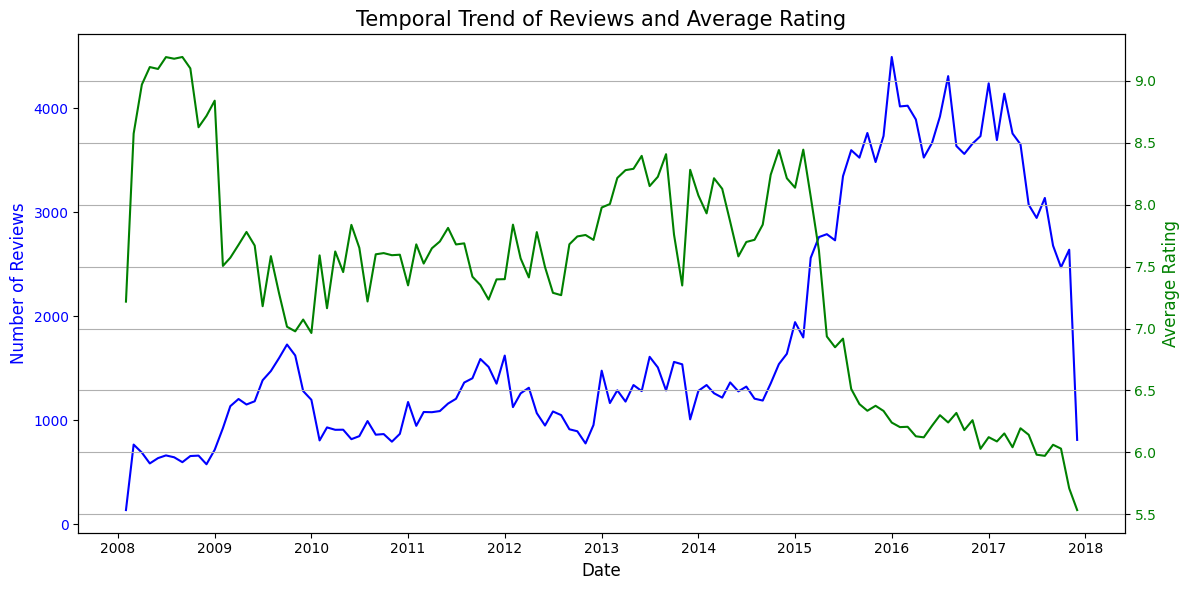

In [9]:
# Aggregating data by month (number of reviews and average rating)
temporal_data = data_original.groupby('year_month').agg(
    num_reviews=('review', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

# Convert year_month back to datetime for proper plotting
temporal_data['year_month'] = temporal_data['year_month'].dt.to_timestamp()

# Plotting temporal trends
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot number of reviews over time
ax1.plot(temporal_data['year_month'], temporal_data['num_reviews'], color='blue', label='Number of Reviews')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Number of Reviews', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the average rating
ax2 = ax1.twinx()
ax2.plot(temporal_data['year_month'], temporal_data['avg_rating'], color='green', label='Average Rating')
ax2.set_ylabel('Average Rating', fontsize=12, color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Temporal Trend of Reviews and Average Rating', fontsize=15)
plt.grid(True)
plt.tight_layout()

plt.show()

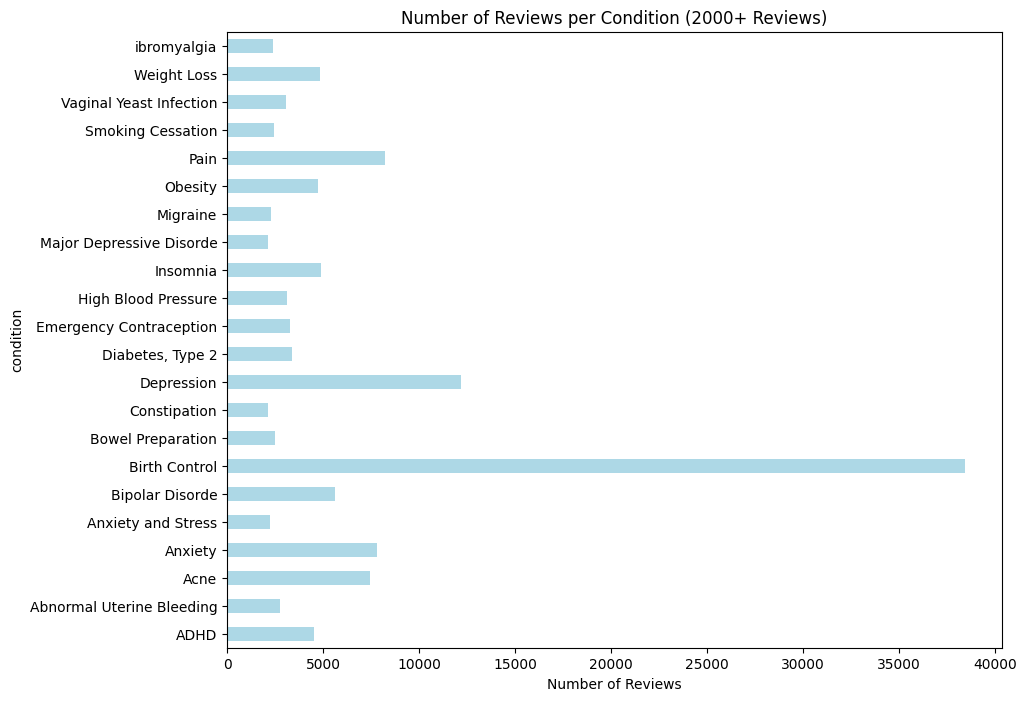

In [10]:
conditions_large_reviews = condition_review_counts[condition_review_counts >= 2000]

plt.figure(figsize=(12, 5))
conditions_large_reviews.plot(kind="barh", figsize=(10, 8), color="lightblue")
plt.title("Number of Reviews per Condition (2000+ Reviews)")
plt.xlabel("Number of Reviews")
plt.show()

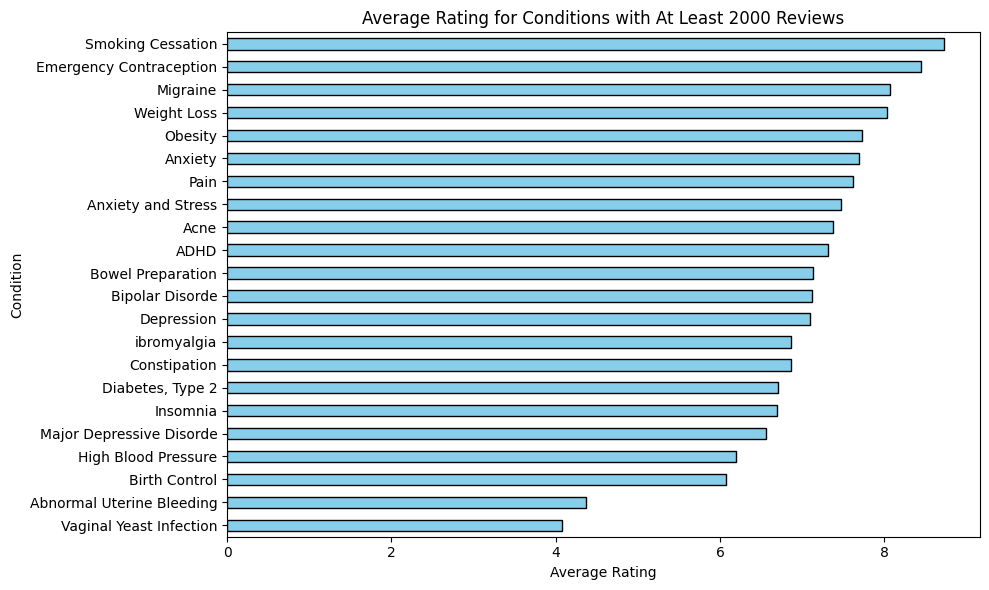

In [11]:
# Filter conditions with at least 2000 reviews
conditions_at_least_2000_reviews = condition_review_counts[condition_review_counts >= 2000].index
filtered_avg_ratings_2000 = avg_rating_per_condition.loc[conditions_at_least_2000_reviews]

plt.figure(figsize=(10, 6))
filtered_avg_ratings_2000.sort_values().plot(kind="barh", color="skyblue", edgecolor="black")
plt.title("Average Rating for Conditions with At Least 2000 Reviews")
plt.xlabel("Average Rating")
plt.ylabel("Condition")
plt.tight_layout()

# Show the plot
plt.show()

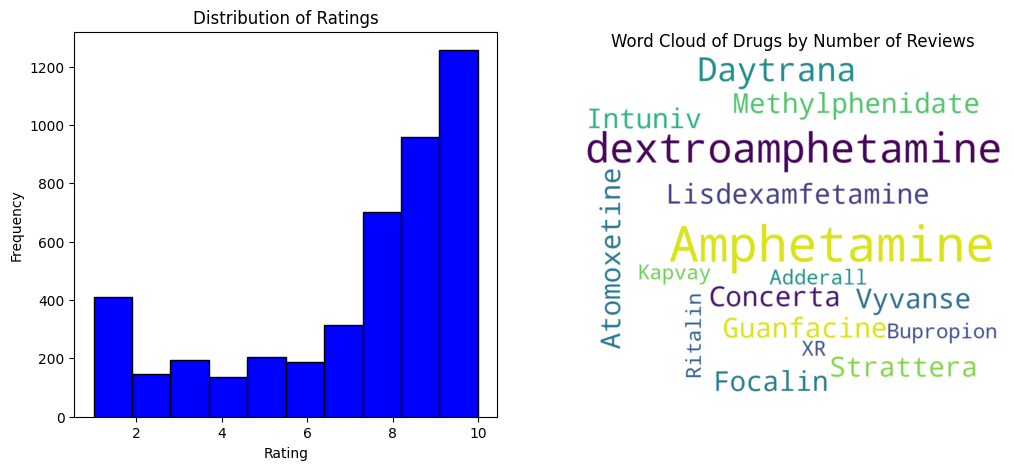

<Figure size 640x480 with 0 Axes>

In [12]:
adhd = data_original[data_original["condition"] == "ADHD"]

plt.figure(figsize=(12, 5))

# Histogram for "rating"
plt.subplot(1, 2, 1)
plt.hist(adhd["rating"], bins=10, color="blue", edgecolor="black")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")


# Generate a string of all drug names repeated based on their counts
drug_counts = adhd["drugName"].head(30).value_counts()
drug_string = " ".join([f"{drug} " * count for drug, count in drug_counts.items()])

# Create the word cloud
wordcloud = WordCloud(width=1000, height=800, background_color="white").generate(drug_string)

# Plot the word cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Turn off the axis
plt.title("Word Cloud of Drugs by Number of Reviews")
plt.show()

# Display the plots
plt.tight_layout()
plt.show()

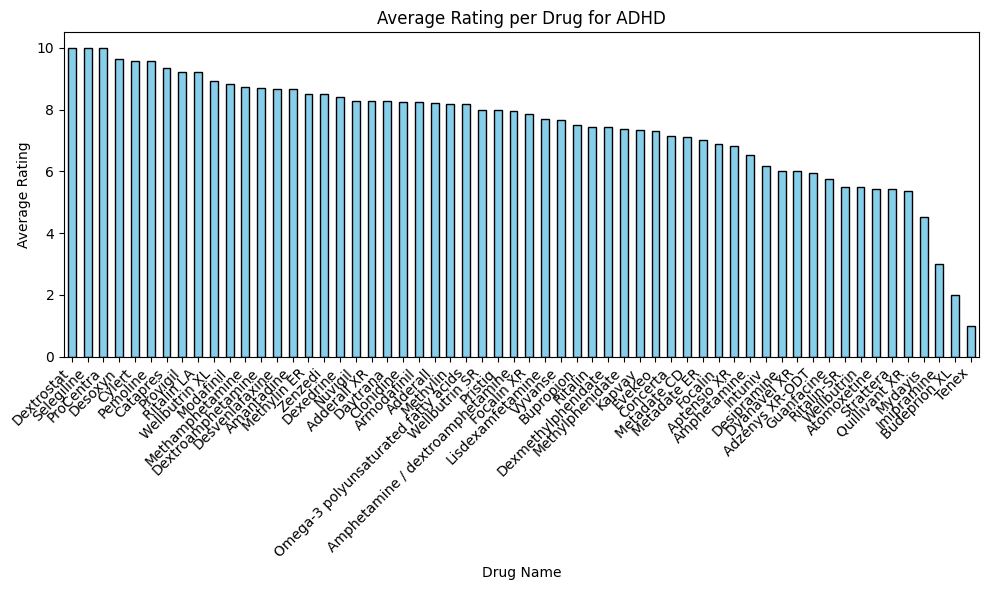

In [13]:
# Calculate the average rating for each drug
avg_rating_per_drug = adhd.groupby("drugName")["rating"].mean()

# Plotting the average rating per drug
plt.figure(figsize=(10, 6))
avg_rating_per_drug.sort_values(ascending=False).plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Rating per Drug for ADHD")
plt.xlabel("Drug Name")
plt.ylabel("Average Rating")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

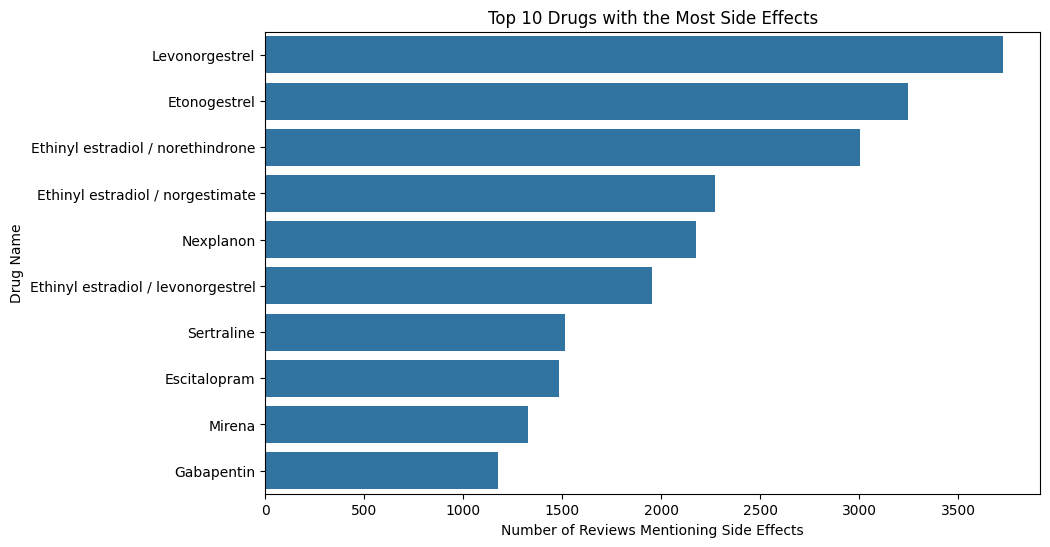

In [14]:
# Import local module helper function that checks if side effects are mentioned in a review.
from utils.side_effects import check_side_effects

# Apply the function to the review text and create the 'side_effects' column
data_original['side_effects'] = data_original['review'].apply(check_side_effects)

# Check the distribution of the new target variable
side_effect_counts = data_original['side_effects'].value_counts()
#print(f"Side Effect Target Distribution:\n{side_effect_counts}")

# Group by drug name and sum the 'side_effects' column to count how many reviews mention side effects for each drug
side_effects_by_drug = data_original.groupby('drugName')['side_effects'].sum().reset_index()

# Sort the results to find the drugs with the most side effects
side_effects_by_drug_sorted = side_effects_by_drug.sort_values(by='side_effects', ascending=False)

# Plot the top 10 drugs with the most side effects
plt.figure(figsize=(10, 6))
sns.barplot(x='side_effects', y='drugName', data=side_effects_by_drug_sorted.head(10))
plt.title('Top 10 Drugs with the Most Side Effects')
plt.xlabel('Number of Reviews Mentioning Side Effects')
plt.ylabel('Drug Name')
plt.show()

Average rating for negative sentiment (sentiment < 0): 6.08
Average rating for neutral/positive sentiment (sentiment >= 0): 7.94


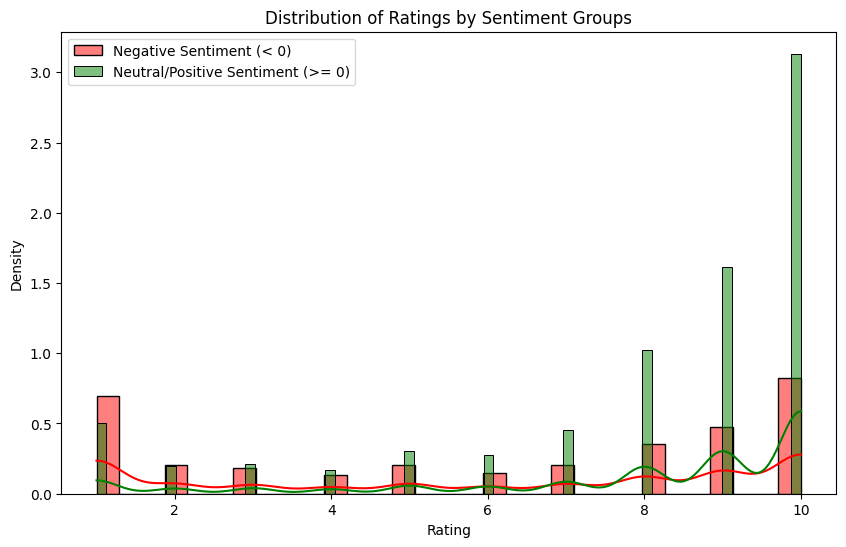

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
sid = SentimentIntensityAnalyzer()

# Split the data into 75% training and 25% testing
train_df, test_df = train_test_split(data_original, test_size=0.25, random_state=42)
# Preprocess text for sentiment analysis (get sentiment score from review text)
data_original['sentiment'] = data_original['review'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Separate the data into two groups: negative (sentiment < 0) and neutral/positive (sentiment >= 0)
negative = data_original[data_original['sentiment'] < 0]
neutral_positive = data_original[data_original['sentiment'] >= 0]

avg_rating_negative = negative['rating'].mean()
avg_rating_neutral_positive = neutral_positive['rating'].mean()

# Print the results
print(f"Average rating for negative sentiment (sentiment < 0): {avg_rating_negative:.2f}")
print(f"Average rating for neutral/positive sentiment (sentiment >= 0): {avg_rating_neutral_positive:.2f}")

# plot the distribution of ratings for each sentiment group
plt.figure(figsize=(10, 6))
sns.histplot(negative['rating'], color='red', label='Negative Sentiment (< 0)', kde=True, stat='density')
sns.histplot(neutral_positive['rating'], color='green', label='Neutral/Positive Sentiment (>= 0)', kde=True, stat='density')
plt.title('Distribution of Ratings by Sentiment Groups')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.legend()
plt.show()

Train Accuracy: 0.7290484757683845
Test Accuracy: 0.7173859896567936
              precision    recall  f1-score   support

           0       0.56      0.21      0.30     15697
           1       0.74      0.93      0.82     37478

    accuracy                           0.72     53175
   macro avg       0.65      0.57      0.56     53175
weighted avg       0.68      0.72      0.67     53175

                               Drug Name                     Condition  \
212040  Ethinyl estradiol / etonogestrel                 Birth Control   
177292                  Dextromethorphan                         Cough   
117623                           Topamax           Migraine Prevention   
32740           Phentermine / topiramate                   Weight Loss   
193096                           Vasotec  Left Ventricular Dysfunction   

        Actual Effectiveness  Predicted Effectiveness  
212040                     0                        1  
177292                     0                   

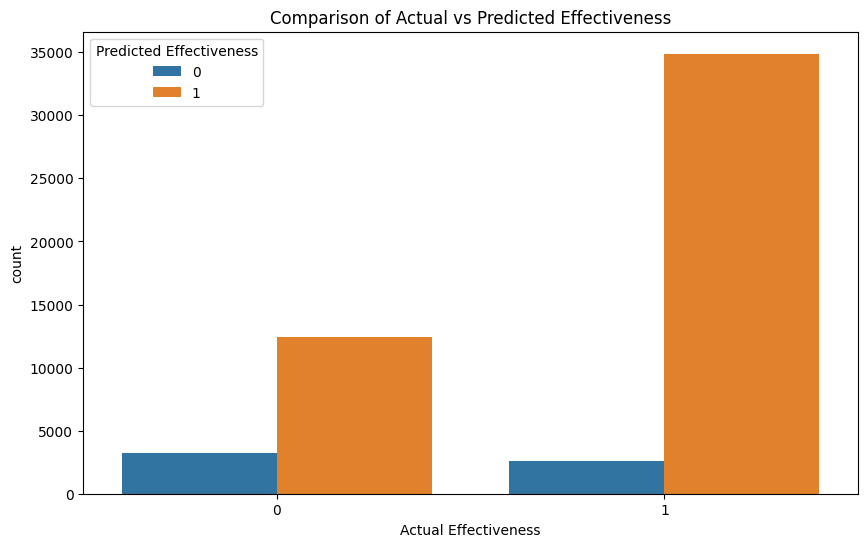

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define effectiveness for training data, here we assumed the ratings > 5 means effective, 
# which can be adjusted withe the previous section of sentiment + rating 
train_df['effective'] = train_df.apply(
    lambda row: 1 if row['rating'] > 5 else 0, axis=1
)

# Define effectiveness for test data in the same way
test_df['effective'] = test_df.apply(
    lambda row: 1 if row['rating'] > 5 else 0, axis=1
)

# Handle missing data
train_df.dropna(subset=['drugName', 'condition', 'rating'], inplace=True)
test_df.dropna(subset=['drugName', 'condition', 'rating'], inplace=True)

# Encode categorical variables (Drug name, Condition)
le_drug = LabelEncoder()
le_condition = LabelEncoder()

train_df['drug_encoded'] = le_drug.fit_transform(train_df['drugName'])
train_df['condition_encoded'] = le_condition.fit_transform(train_df['condition'])

# Define a safe transformation function to handle unseen labels
def safe_transform(encoder, data, default_value=-1):
    return np.array([default_value if label not in encoder.classes_ else encoder.transform([label])[0] for label in data])

# Apply safe transformation on the test data to handle unseen drugs and conditions
test_df['drug_encoded'] = safe_transform(le_drug, test_df['drugName'])
test_df['condition_encoded'] = safe_transform(le_condition, test_df['condition'])

# Define the input features (drug name and condition) and the target variable (effectiveness)
X_train = train_df[['drug_encoded', 'condition_encoded']]
y_train = train_df['effective']

X_test = test_df[['drug_encoded', 'condition_encoded']]
y_test = test_df['effective']

# Train a Random Forest classifier using drug name and condition as input features
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set using drug name and condition
y_pred = clf.predict(X_test)

# Evaluate the model
print(f"Train Accuracy: {accuracy_score(y_train, clf.predict(X_train))}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Create a comparison table of actual vs predicted values
comparison_df = pd.DataFrame({
    'Drug Name': test_df['drugName'],
    'Condition': test_df['condition'],
    'Actual Effectiveness': y_test,
    'Predicted Effectiveness': y_pred
})

print(comparison_df.head())

# Plot the predicted effectiveness for a few drug-condition pairs
plt.figure(figsize=(10, 6))
sns.countplot(x='Actual Effectiveness', hue='Predicted Effectiveness', data=comparison_df)
plt.title('Comparison of Actual vs Predicted Effectiveness')
plt.show()

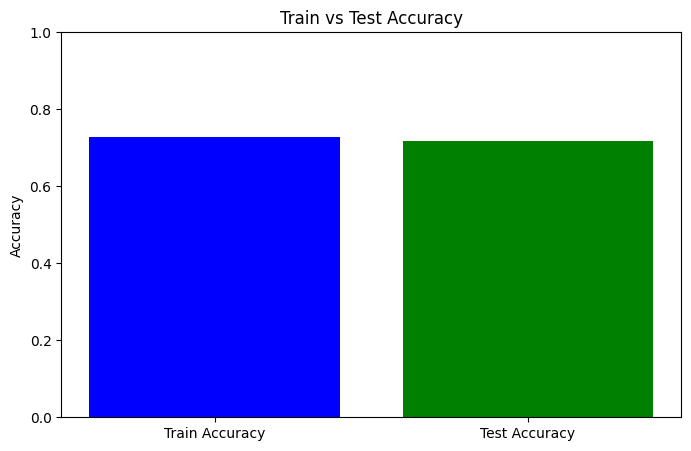

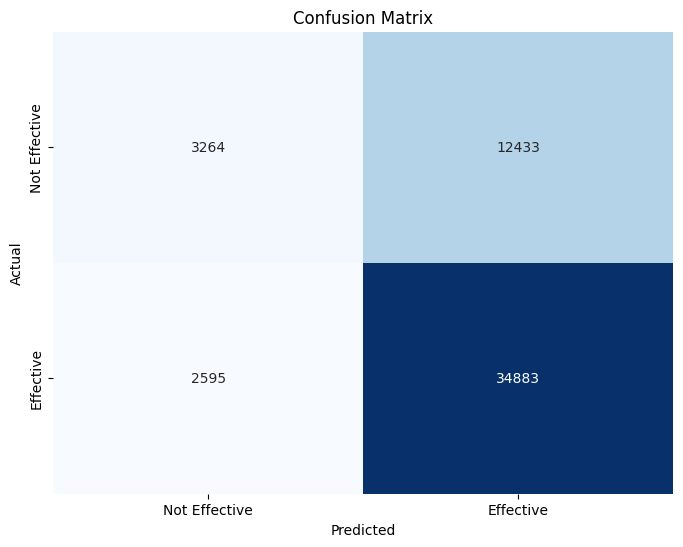

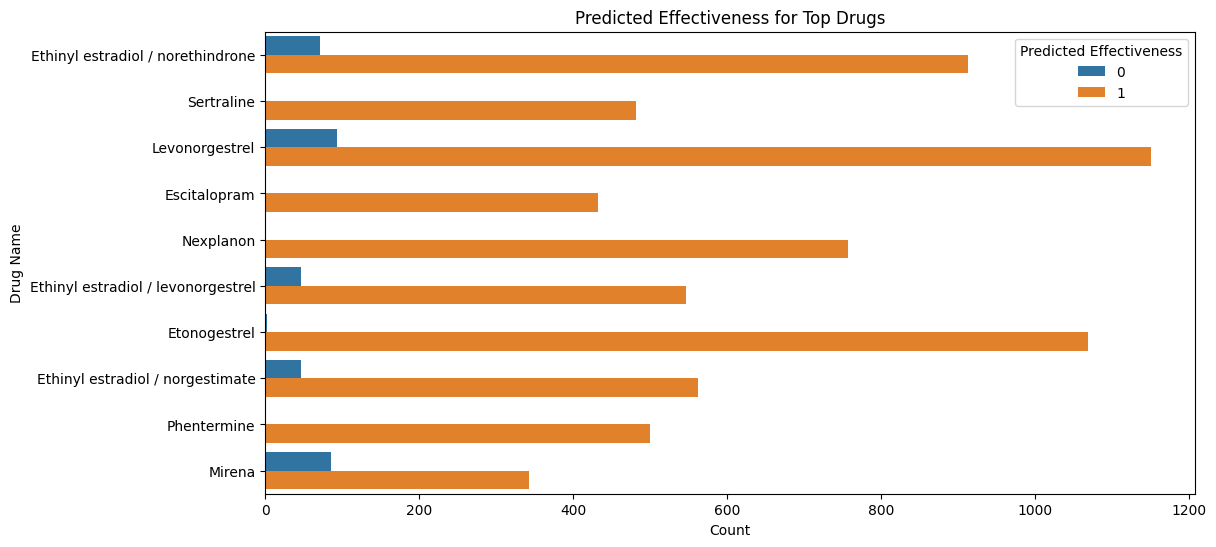

In [17]:
#Some visualizations, we can pick and chose what we want to keep 
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Train and Test Accuracy as a bar plot
plt.figure(figsize=(8, 5))
accuracy_values = [accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, y_pred)]
plt.bar(['Train Accuracy', 'Test Accuracy'], accuracy_values, color=['blue', 'green'])
plt.title('Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Effective', 'Effective'], yticklabels=['Not Effective', 'Effective'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Bar plot of Predicted Effectiveness for different drugs
plt.figure(figsize=(12, 6))
top_drugs = comparison_df['Drug Name'].value_counts().index[:10]
sns.countplot(y='Drug Name', hue='Predicted Effectiveness', data=comparison_df[comparison_df['Drug Name'].isin(top_drugs)])
plt.title('Predicted Effectiveness for Top Drugs')
plt.xlabel('Count')
plt.ylabel('Drug Name')
plt.legend(title='Predicted Effectiveness', loc='upper right')
plt.show()

Correlation Matrix (without Sentiment):
                     id    rating  usefulCount  review_length  side_effects
id             1.000000  0.016090     0.017253       0.007651     -0.002111
rating         0.016090  1.000000     0.235375       0.027199     -0.094916
usefulCount    0.017253  0.235375     1.000000       0.019819     -0.009713
review_length  0.007651  0.027199     0.019819       1.000000      0.303048
side_effects  -0.002111 -0.094916    -0.009713       0.303048      1.000000


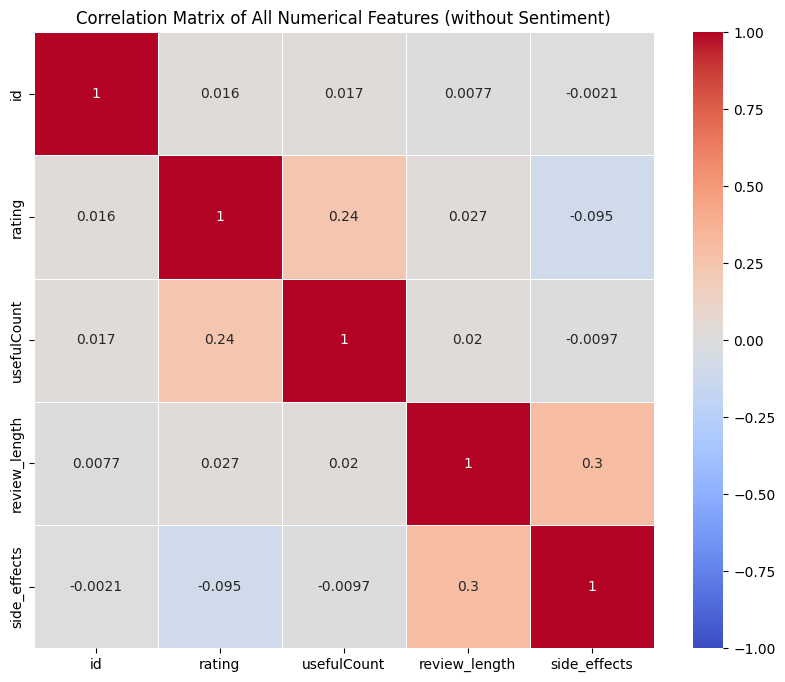

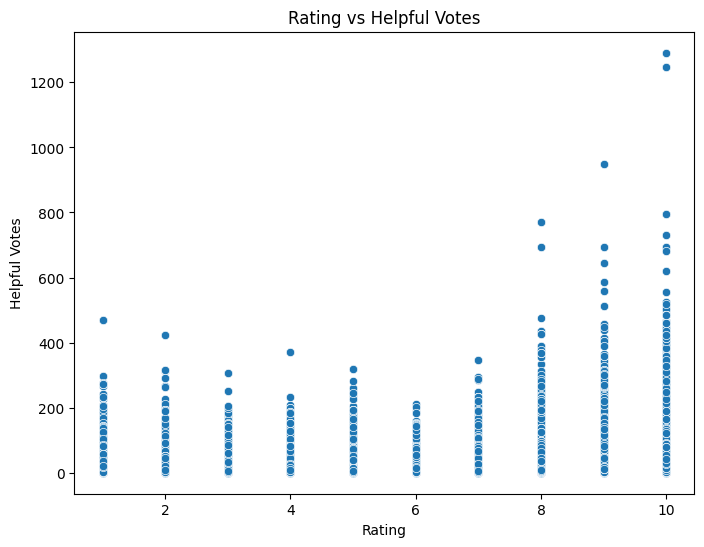

In [18]:
# Some additional descriptive analysis that could be useful:
# Select all numerical columns except 'sentiment'
numerical_columns = data_original.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns.drop('sentiment', errors='ignore')  # Exclude sentiment if it's present

# Calculate the correlation matrix for the selected numerical features
correlation_matrix = data_original[numerical_columns].corr()

# Display the correlation matrix
print("Correlation Matrix (without Sentiment):")
print(correlation_matrix)

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, linewidths=0.5)
plt.title('Correlation Matrix of All Numerical Features (without Sentiment)')
plt.show()

# Scatter plot for rating vs usefulCount (helpful votes)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='rating', y='usefulCount', data=data_original)
plt.title('Rating vs Helpful Votes')
plt.xlabel('Rating')
plt.ylabel('Helpful Votes')
plt.show()

Top 10 Most Reviewed Drugs:
drugName
Levonorgestrel                        4896
Etonogestrel                          4402
Ethinyl estradiol / norethindrone     3619
Nexplanon                             2883
Ethinyl estradiol / norgestimate      2682
Ethinyl estradiol / levonorgestrel    2400
Phentermine                           2077
Sertraline                            1859
Escitalopram                          1739
Mirena                                1647
Name: count, dtype: int64


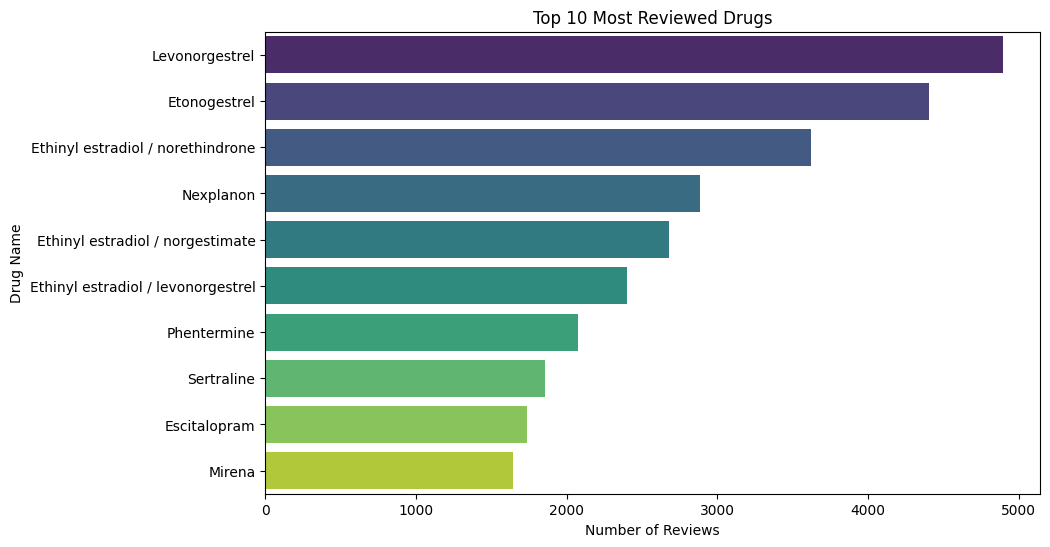

Top 10 Most Reviewed Conditions:
condition
Birth Control      38436
Depression         12164
Pain                8245
Anxiety             7812
Acne                7435
Bipolar Disorde     5604
Insomnia            4904
Weight Loss         4857
Obesity             4757
ADHD                4509
Name: count, dtype: int64


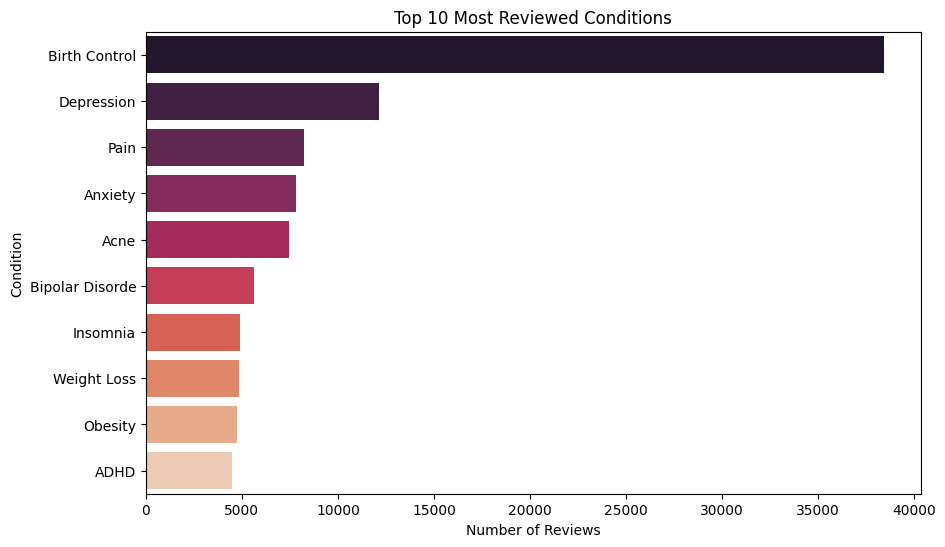

Top 10 Drug-Condition Pairs by Number of Reviews:
                                drugName                condition  num_reviews
3073                        Etonogestrel            Birth Control         4394
3049   Ethinyl estradiol / norethindrone            Birth Control         3081
4442                      Levonorgestrel            Birth Control         2884
5520                           Nexplanon            Birth Control         2883
3040  Ethinyl estradiol / levonorgestrel            Birth Control         2107
3058    Ethinyl estradiol / norgestimate            Birth Control         2097
4443                      Levonorgestrel  Emergency Contraception         1651
6136                         Phentermine              Weight Loss         1650
3943                            Implanon            Birth Control         1496
5099                          Miconazole  Vaginal Yeast Infection         1338


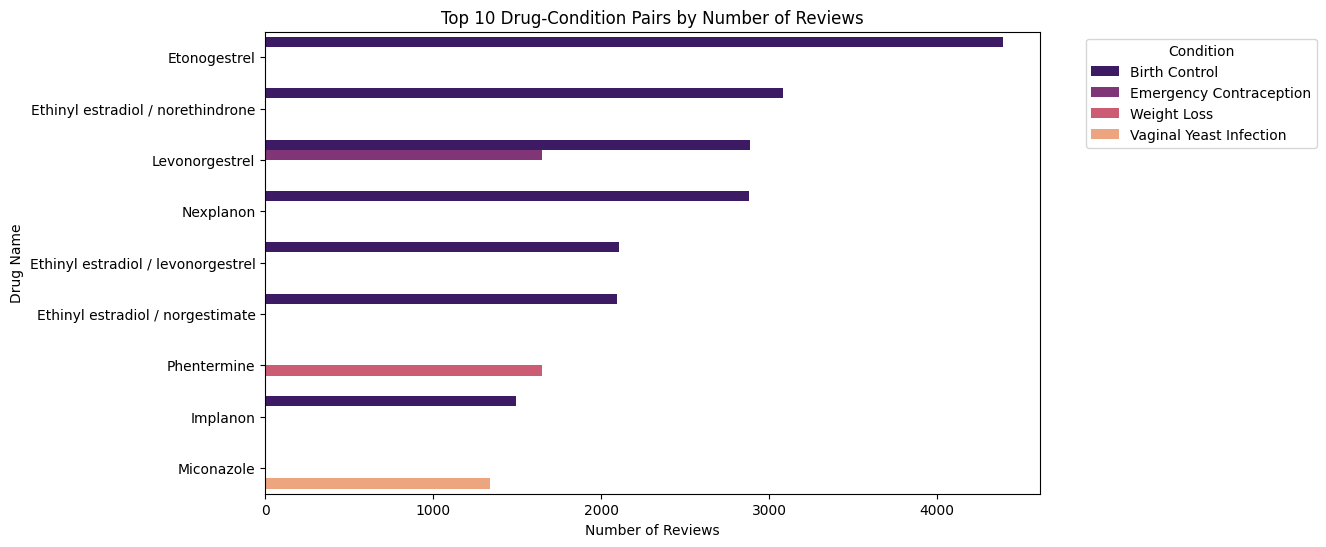

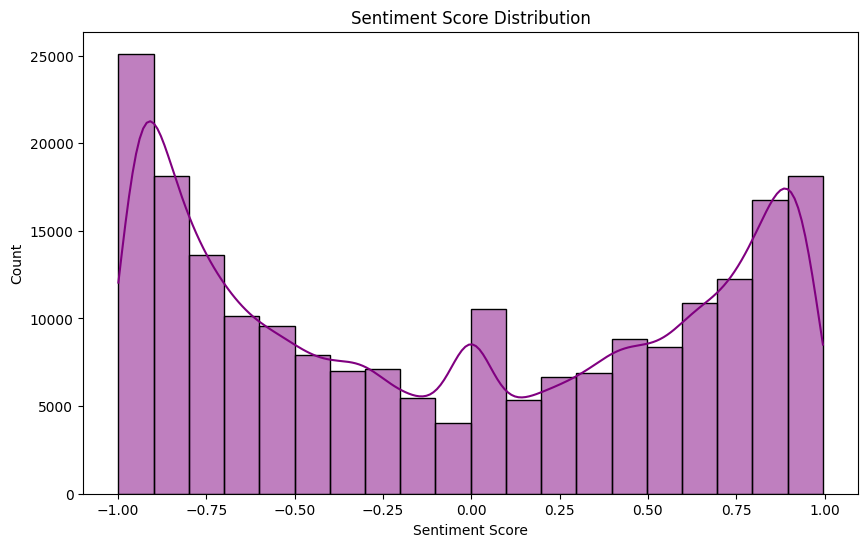

Sentiment Distribution:
Negative: 108118 reviews
Neutral: 6691 reviews
Positive: 97889 reviews


In [19]:
# Top 10 most common drugs
top_drugs = data_original['drugName'].value_counts().head(10)
print("Top 10 Most Reviewed Drugs:")
print(top_drugs)

# Visualize the top 10 most common drugs
plt.figure(figsize=(10, 6))
sns.barplot(x=top_drugs.values, y=top_drugs.index, hue=top_drugs.index, legend=False, palette="viridis")
plt.title('Top 10 Most Reviewed Drugs')
plt.xlabel('Number of Reviews')
plt.ylabel('Drug Name')
plt.show()

# Top 10 most common conditions
top_conditions = data_original['condition'].value_counts().head(10)
print("Top 10 Most Reviewed Conditions:")
print(top_conditions)

# Visualize the top 10 conditions
plt.figure(figsize=(10, 6))
sns.barplot(x=top_conditions.values, y=top_conditions.index, hue=top_conditions.index, legend=False, palette="rocket")
plt.title('Top 10 Most Reviewed Conditions')
plt.xlabel('Number of Reviews')
plt.ylabel('Condition')
plt.show()

# Number of reviews per drug and condition
reviews_per_drug_condition = data_original.groupby(['drugName', 'condition']).size().reset_index(name='num_reviews')
top_drug_condition = reviews_per_drug_condition.sort_values(by='num_reviews', ascending=False).head(10)

print("Top 10 Drug-Condition Pairs by Number of Reviews:")
print(top_drug_condition)

# Visualize the top drug-condition pairs
plt.figure(figsize=(10, 6))
sns.barplot(x='num_reviews', y='drugName', hue='condition', data=top_drug_condition, palette="magma")
plt.title('Top 10 Drug-Condition Pairs by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Drug Name')
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(data_original['sentiment'], bins=20, kde=True, color='purple')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

# Show how many reviews have positive, negative, or neutral sentiment
print("Sentiment Distribution:")
sentiment_labels = ['Negative', 'Neutral', 'Positive']
sentiment_distribution = [
    (data_original['sentiment'] < 0).sum(),
    (data_original['sentiment'] == 0).sum(),
    (data_original['sentiment'] > 0).sum()
]
for label, count in zip(sentiment_labels, sentiment_distribution):
    print(f"{label}: {count} reviews")

In [20]:
import ipywidgets as widgets
from IPython.display import display

# Define effectiveness using percentiles of the ratings to add more variance
# Compute percentiles and scale effectiveness
data_original['percentile_effectiveness'] = data_original.groupby('condition')['rating'].rank(pct=True) * 100  # Rank ratings per condition and scale to 0-100%

# Group by condition and drug, then calculate the mean percentile effectiveness as the confidence
effectiveness_by_condition = data_original.groupby(['condition', 'drugName']).agg(
    average_rating=('rating', 'mean'),
    confidence=('percentile_effectiveness', 'mean')  # Now using percentile effectiveness as confidence
).reset_index()

# Function to get the best drug for a given condition
def get_best_drug(condition):
    condition_data = effectiveness_by_condition[effectiveness_by_condition['condition'] == condition]
    
    if condition_data.empty:
        return "No data available", 0
    
    best_drug = condition_data.sort_values(by='confidence', ascending=False).iloc[0]
    
    return best_drug['drugName'], best_drug['confidence']  # Return the confidence based on percentile effectiveness

# Create a dropdown widget for selecting a condition
condition_dropdown = widgets.Dropdown(
    options=data_original['condition'].unique(),
    description='Condition:',
    disabled=False
)

# Create a label widget to display the best drug and confidence
result_label = widgets.Label(value="Select a condition to see the best drug")

# Function to update the result when a condition is selected
def on_condition_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_condition = change['new']
        best_drug, confidence = get_best_drug(selected_condition)
        result_label.value = f"Best Drug: {best_drug}\nConfidence: {confidence:.2f}%"

# Attach the function to the dropdown widget
condition_dropdown.observe(on_condition_change)

# Display the dropdown and result label in the notebook
display(condition_dropdown)
display(result_label)

Dropdown(description='Condition:', options=('Left Ventricular Dysfunction', 'ADHD', 'Birth Control', 'Opiate D…

Label(value='Select a condition to see the best drug')